In [22]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [23]:
import random
# import tools
import numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import knapsack

In [24]:
# create the knapsack problem instance to be used:
knapsack = knapsack.Knapsack01Problem()

In [25]:
# Genetic Algorithm constants:
POPULATION_SIZE = 100
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.3   # probability for mutating an individual
MAX_GENERATIONS = 10000
HALL_OF_FAME_SIZE = 1

In [26]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [27]:
def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1], offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

In [28]:
#Evolution algorithm
def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    # elapsed is calculated as seconds
    gen, elapsed = 1, 0
    start = time.time()
    while gen <= ngen and elapsed < 10:
        
        gen += 1

        #Time 
        elapsed = time.time() - start 
        
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook, elapsed 

In [29]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, len(knapsack))

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

/home/ngctnnnn/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/ngctnnnn/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [30]:
# fitness calculation
def knapsackValue(individual):
    return knapsack.getValue(individual),  # return a tuple

In [31]:
toolbox.register("evaluate", knapsackValue)

# genetic operators:mutFlipBit

# Tournament selection with tournament size of 3:
toolbox.register("select", tools.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", tools.cxTwoPoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/len(knapsack))

In [32]:
# Genetic Algorithm flow:
def main():
    
    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", numpy.max)
    stats.register("avg", numpy.mean)


    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook, minutes = eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)


    # print best solution found:
    best = hof.items[0]
    print(end = '\n')
    print("-- Executed time = " + str(minutes) + " sec", end = '\n')
    print("-- Best Ever Individual = ", best)
    print("-- Best Ever Fitness = ", best.fitness.values[0])

    print("-- Knapsack Items = ")
    knapsack.printItems(best)

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:x
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.show()

gen	nevals	max	avg   
0  	100   	885	585.59
2  	94    	900	708.47
3  	91    	950	787.58
4  	95    	950	824.99
5  	95    	950	840.33
6  	95    	950	867.91
7  	91    	980	862.55
8  	93    	980	880.32
9  	96    	1005	892.8 
10 	92    	1005	915.46
11 	91    	1005	934.74
12 	93    	1005	946.14
13 	91    	1005	949.77
14 	94    	1030	962.36
15 	93    	1030	975.62
16 	91    	1030	981.21
17 	96    	1030	976.18
18 	87    	1030	974.86
19 	96    	1030	972.77
20 	95    	1030	989.67
21 	90    	1030	998.84
22 	93    	1030	1008.21
23 	95    	1030	1021.08
24 	97    	1030	1001.74
25 	95    	1030	1007.86
26 	93    	1030	1016.24
27 	95    	1030	1016.23
28 	92    	1030	1010.65
29 	95    	1030	1007.63
30 	94    	1030	1009.64
31 	91    	1030	1011.2 
32 	92    	1030	1013.8 
33 	99    	1030	1012.79
34 	93    	1030	1012.37
35 	94    	1030	1010.87
36 	88    	1030	1006.56
37 	99    	1030	1011.3 
38 	96    	1030	1006.25
39 	95    	1030	1018.94
40 	97    	1030	1001.09
41 	94    	1030	1010.66
42 	93    	1030	1016.56

524	85    	1030	1011.73
525	92    	1030	1016.33
526	95    	1030	1013.66
527	90    	1030	1018.47
528	97    	1030	1012.24
529	96    	1030	1009.27
530	99    	1030	1012.89
531	94    	1030	1014.15
532	90    	1030	1011.96
533	92    	1030	1013.56
534	91    	1030	1005.74
535	89    	1030	1014.01
536	99    	1030	1005.1 
537	96    	1030	1009.19
538	95    	1030	1013.11
539	92    	1030	1005.31
540	95    	1030	1006.94
541	89    	1030	1016.05
542	97    	1030	1007.9 
543	92    	1030	1016.55
544	86    	1030	1010.99
545	95    	1030	1011.79
546	88    	1030	1002.99
547	94    	1030	998.3  
548	90    	1030	1005.81
549	99    	1030	1013.12
550	95    	1030	1016.52
551	93    	1030	1014.61
552	88    	1030	1013.59
553	96    	1030	1005.52
554	92    	1030	1012.44
555	96    	1030	1016.49
556	89    	1030	1020.19
557	94    	1030	1007.17
558	98    	1030	1008.97
559	93    	1030	1010.69
560	93    	1030	1011.82
561	88    	1030	1010.45
562	98    	1030	1016.67
563	96    	1030	1015.64
564	97    	1030	1008.01
565	91    	1030	

974	93    	1030	1013.21
975	92    	1030	1009.91
976	93    	1030	1010.55
977	96    	1030	1012.16
978	98    	1030	1015.06
979	95    	1030	1014.24
980	90    	1030	1014.32
981	95    	1030	1005.26
982	96    	1030	1009.42
983	89    	1030	1014.25
984	89    	1030	1004.05
985	88    	1030	1003.03
986	91    	1030	1010.57
987	98    	1030	1007.27
988	94    	1030	1010.71
989	95    	1030	1004.6 
990	93    	1030	1009.01
991	92    	1030	1014.48
992	92    	1030	1012.9 
993	92    	1030	1004.66
994	94    	1030	995.57 
995	91    	1030	1017.81
996	97    	1030	1017.35
997	94    	1030	999.93 
998	94    	1030	1009.32
999	86    	1030	1017.23
1000	91    	1030	1006.89
1001	98    	1030	1004.9 
1002	93    	1030	1015.44
1003	94    	1030	1014.56
1004	91    	1030	1004.97
1005	99    	1030	1014.35
1006	97    	1030	1003.89
1007	88    	1030	1004.3 
1008	94    	1030	1008.79
1009	92    	1030	1009.61
1010	88    	1030	1008.03
1011	98    	1030	1007.88
1012	93    	1030	1011.46
1013	93    	1030	1006.15
1014	96    	1030	1003.2 
1

1827	93    	1030	1009.43
1828	96    	1030	1002.79
1829	88    	1030	1009.7 
1830	91    	1030	1006.71
1831	98    	1030	1008.42
1832	88    	1030	1014.37
1833	94    	1030	1000.93
1834	92    	1030	1013.45
1835	96    	1030	1002.67
1836	97    	1030	1009.97
1837	96    	1030	1016.83
1838	93    	1030	1006.47
1839	95    	1030	1007.77
1840	91    	1030	1012.55
1841	94    	1030	1008.84
1842	96    	1030	1012.81
1843	91    	1030	1016.74
1844	90    	1030	1007.12
1845	93    	1030	1002.1 
1846	95    	1030	1006.73
1847	93    	1030	1015.05
1848	88    	1030	1014.06
1849	94    	1030	1012.37
1850	98    	1030	1015.43
1851	88    	1030	1009.3 
1852	95    	1030	1007.11
1853	90    	1030	1007.55
1854	98    	1030	1002.42
1855	86    	1030	1010.31
1856	93    	1030	1005.03
1857	95    	1030	1005.37
1858	96    	1030	1019.99
1859	96    	1030	1009.18
1860	93    	1030	1007.13
1861	96    	1030	1005.08
1862	92    	1030	1016.36
1863	87    	1030	1012.72
1864	96    	1030	1012.06
1865	92    	1030	1012.51
1866	93    	1030	1011.58


2326	92    	1030	1007.73
2327	97    	1030	1014.49
2328	88    	1030	1003.36
2329	93    	1030	1006.69
2330	95    	1030	1005.41
2331	96    	1030	1008.26
2332	89    	1030	1007.93
2333	94    	1030	1005.88
2334	89    	1030	1007.92
2335	96    	1030	1003.72
2336	89    	1030	1009.94
2337	95    	1030	1006.46
2338	91    	1030	1006.69
2339	94    	1030	1012.56
2340	95    	1030	1006.5 
2341	91    	1030	1016.53
2342	98    	1030	1005.91
2343	87    	1030	1006.8 
2344	93    	1030	1014.86
2345	93    	1030	1004.82
2346	89    	1030	1015.49
2347	89    	1030	1002.23
2348	88    	1030	1012.43
2349	93    	1030	1006.99
2350	93    	1030	1002.05
2351	92    	1030	1010.93
2352	88    	1030	1007.12
2353	95    	1030	1012.89
2354	93    	1030	1013.11
2355	86    	1030	1003.59
2356	89    	1030	1002.87
2357	90    	1030	1017.24
2358	97    	1030	1011.52
2359	95    	1030	1005.32
2360	93    	1030	1018.05
2361	89    	1030	1011.34
2362	93    	1030	1007.63
2363	87    	1030	1009   
2364	92    	1030	1005.68
2365	91    	1030	1013.46


2825	95    	1030	1011.14
2826	94    	1030	1002.41
2827	94    	1030	1011.21
2828	89    	1030	1014.67
2829	91    	1030	1009.46
2830	98    	1030	1012.67
2831	91    	1030	1007.82
2832	98    	1030	1017.64
2833	87    	1030	1016.19
2834	97    	1030	1005.61
2835	90    	1030	1011.19
2836	96    	1030	999.99 
2837	96    	1030	1011.17
2838	96    	1030	1008.83
2839	93    	1030	1015.99
2840	97    	1030	1009.46
2841	92    	1030	1008.87
2842	95    	1030	1004.11
2843	93    	1030	1004.05
2844	96    	1030	1001.75
2845	95    	1030	1002.79
2846	97    	1030	996.46 
2847	90    	1030	1004.05
2848	91    	1030	1003.77
2849	93    	1030	999.06 
2850	98    	1030	1008.5 
2851	92    	1030	1003.23
2852	97    	1030	993.64 
2853	90    	1030	1013.89
2854	93    	1030	1013.32
2855	92    	1030	1010.98
2856	95    	1030	1012.27
2857	92    	1030	1008.55
2858	93    	1030	1010.29
2859	87    	1030	1016.57
2860	95    	1030	1012.92
2861	95    	1030	1007.19
2862	91    	1030	1012.01
2863	93    	1030	1013.93
2864	98    	1030	1015.03


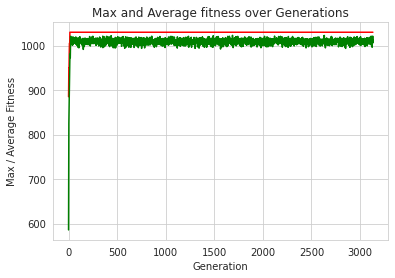

In [33]:
if __name__ == "__main__":
    main()